In [1]:
import torch  
import torch.nn as nn  
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as D
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau, StepLR  

# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class Input:
    """
    Input grid initializer for 2D spatial-temporal problems.
    Handles spatial grids, time sequences, and boundary/collocation point generation.
    """

    def __init__(self, x):
        """
        Initializes the input with a 1D spatial grid.

        Args:
            x (torch.Tensor or np.ndarray): 1D array of spatial coordinates.
        """
        self.x: torch.Tensor
        self.X: torch.Tensor
        self.Y: torch.Tensor
        self.t: torch.Tensor  # Will have requires_grad=True

        self._initialize(x)

    def _initialize(self, x):
        """
        Initializes spatial grid and mesh.

        Args:
            x (torch.Tensor or np.ndarray): 1D spatial grid.
        """
        self.x = x.to(device) if isinstance(x, torch.Tensor) else torch.from_numpy(x).float()
        x_np = self.x.cpu().numpy()
        Xtemp, Ytemp = np.meshgrid(x_np, x_np, indexing='ij')
        self.X = torch.from_numpy(Xtemp.ravel()).float().to(device)
        self.Y = torch.from_numpy(Ytemp.ravel()).float().to(device)
        self.update_t()

    def update_t(self, tfinal=1500, num_frames=100):
        """
        Creates the temporal sampling vector `t`.

        Args:
            tfinal (float): Final time for the simulation.
            num_frames (int): Number of frames (time steps).
        """
        t_arange = torch.arange(num_frames, dtype=torch.float32) / num_frames
        t_rand = torch.rand(num_frames, dtype=torch.float32) / num_frames
        self.t = tfinal * (t_arange + t_rand)
        self.t.requires_grad_()
        self.t = self.t.to(device)

    def get_IC(self):
        """
        Returns initial condition grid points (X, Y).

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Flattened X and Y coordinates.
        """
        return self.X.to(device), self.Y.to(device)

    def get_T(self, t=0.0):
        """
        Returns a constant time tensor T with the same shape as X.

        Args:
            t (float): Time value to replicate.

        Returns:
            torch.Tensor: Constant T tensor with requires_grad.
        """
        T = t * torch.ones_like(self.X).float().to(device)
        T.requires_grad_()
        return T

    def get_BC(self):
        """
        Constructs boundary coordinates (periodic boundaries on square domain).

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: 
            X and Y for two sets of boundary conditions, repeated over time.
        """
        lenx = len(self.x)
        num_frames = len(self.t)
        Xbc1 = torch.cat([self.x[0].repeat(lenx), self.x], dim=0).repeat(num_frames)
        Ybc1 = torch.cat([self.x, self.x[0].repeat(lenx)], dim=0).repeat(num_frames)
        Xbc2 = torch.cat([self.x[-1].repeat(lenx), self.x], dim=0).repeat(num_frames)
        Ybc2 = torch.cat([self.x, self.x[-1].repeat(lenx)], dim=0).repeat(num_frames)
        return Xbc1.to(device), Ybc1.to(device), Xbc2.to(device), Ybc2.to(device)

    def get_TBC(self):
        """
        Returns repeated time values for boundary conditions.

        Returns:
            torch.Tensor: Repeated time values for BC points.
        """
        return self.t.repeat_interleave(len(self.x) * 2).to(device)

    def get_Colloc(self):
        """
        Returns spatial collocation points repeated for all time steps.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: X and Y coordinates for collocation points.
        """
        num_frames = len(self.t)
        return self.X.repeat(num_frames).to(device), self.Y.repeat(num_frames).to(device)

    def get_TColloc(self):
        """
        Returns repeated time values for collocation points.

        Returns:
            torch.Tensor: Time tensor repeated for each (X, Y) grid point.
        """
        return self.t.repeat_interleave(len(self.X)).to(device)

    def get_k2(self):
        """
        Computes the squared wavenumber field `k2` and a dealiasing mask.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: k^2 tensor and dealiasing boolean mask.
        """
        kx = torch.fft.fftfreq(len(self.x), d=(self.x[1] - self.x[0]).item()) * 2 * torch.pi
        kx = kx.float()
        mesh = torch.meshgrid(kx, kx, indexing="ij")
        k = torch.stack(mesh, dim=0)
        k2 = torch.sum(k * k, dim=0)

        kmax_dealias = (2 / 3) * kx.max()
        dealias = (torch.abs(k[0]) < kmax_dealias) & (torch.abs(k[1]) < kmax_dealias)

        return k2.to(device), dealias.to(device)

    def get_uic(self, seed=12345, flatten=True):
        """
        Generates initial condition `u(x, y, t=0)`.

        Args:
            seed (int): Random seed for reproducibility.
            flatten (bool): If True, flattens the output to 1D.

        Returns:
            torch.Tensor: Initial condition tensor.
        """
        N = len(self.x)
        rng = np.random.default_rng(seed)
        u = -0.285 + (0.285 * 0.02) * rng.standard_normal((N, N), dtype=np.float32)
        u = torch.from_numpy(u).float().to(device)
        return u.ravel() if flatten else u


In [3]:
class AlphaNet(nn.Module):
    """
    Neural network that outputs the mean (`mu`) and softplus-transformed log standard deviation (`logsig`)
    of a learned distribution, conditioned on spatial coordinates (X, Y), time (T), and a scalar parameter g.

    Attributes:
        hidden_layers (nn.ModuleList): List of hidden layers.
        mu_layer (nn.Linear): Output layer for mean prediction.
        logsig_layer (nn.Linear): Output layer for log standard deviation prediction.
    """

    def __init__(self, hidden_features: list[int], in_features: int = 4):
        """
        Initializes the AlphaNet model.

        Args:
            hidden_features (list[int]): Number of neurons in each hidden layer.
            in_features (int): Number of input features. Default is 4 (X, Y, T, g).
        """
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        
        # Build hidden layers
        prev_features = in_features
        for features in hidden_features:
            self.hidden_layers.append(nn.Linear(prev_features, features))
            prev_features = features
        
        # Output layers for mean and log-variance
        self.mu_layer = nn.Linear(prev_features, 1)
        self.logsig_layer = nn.Linear(prev_features, 1)

    def forward(self, X: torch.Tensor, Y: torch.Tensor, T: torch.Tensor, g: float):
        """
        Forward pass through the network.

        Args:
            X (torch.Tensor): X coordinates, shape (N,).
            Y (torch.Tensor): Y coordinates, shape (N,).
            T (torch.Tensor): Time values, shape (N,).
            g (float): Scalar global parameter (e.g. physical coefficient).

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: 
                - mu: Predicted mean (shape: [N])
                - logsig: Predicted softplus-transformed standard deviation (shape: [N])
        """
        G = g * torch.ones_like(X)
        inp = torch.stack([X, Y, T, G], dim=1)

        for layer in self.hidden_layers:
            inp = F.silu(layer(inp))  # or use torch.tanh(layer(inp)) if preferred

        mu = self.mu_layer(inp).squeeze(-1)
        logsig = F.softplus(self.logsig_layer(inp)).squeeze(-1) + 1e-6

        return mu, logsig


In [4]:
def get_u(mu: torch.Tensor, sig: torch.Tensor) -> torch.Tensor:
    """
    Samples from a Gaussian distribution using the reparameterization trick.

    Args:
        mu (torch.Tensor): Mean of the distribution.
        sig (torch.Tensor): Standard deviation of the distribution.

    Returns:
        torch.Tensor: Sampled tensor u.
    """
    epsilon = torch.randn_like(mu)
    u = mu + sig * epsilon
    return u.to(device)


def compute_residual(
    u: torch.Tensor,
    ut: torch.Tensor,
    g: float,
    k2: torch.Tensor,
    dealias: torch.Tensor
) -> torch.Tensor:
    """
    Computes the residual of the PDE in Fourier space for a single frame.

    Args:
        u (torch.Tensor): Solution u at a single frame (2D).
        ut (torch.Tensor): Time derivative of u at the same frame (2D).
        g (float): Physical parameter.
        k2 (torch.Tensor): Wavenumber squared grid (2D).
        dealias (torch.Tensor): Dealiasing mask (2D).

    Returns:
        torch.Tensor: Flattened residual magnitude squared.
    """
    Fut = torch.fft.fft2(ut)
    Fu = torch.fft.fft2(u)
    Fu3 = torch.fft.fft2(u**3) * dealias
    r = Fut + k2 * ((1 - k2)**2 - g) * Fu + k2 * Fu3
    return (r.abs()**2).flatten().to(device)


def get_residual(
    u: torch.Tensor,
    ut: torch.Tensor,
    g: float,
    k2: torch.Tensor,
    dealias: torch.Tensor
) -> torch.Tensor:
    """
    Computes the residuals over multiple frames by batching compute_residual.

    Args:
        u (torch.Tensor): Flattened predicted solution for all frames (shape: [frames * N * N]).
        ut (torch.Tensor): Flattened time derivative for all frames (shape: [frames * N * N]).
        g (float): Physical parameter.
        k2 (torch.Tensor): Wavenumber squared grid (2D).
        dealias (torch.Tensor): Dealiasing mask (2D).

    Returns:
        torch.Tensor: Flattened residuals across all frames.
    """
    grid_dim = k2.shape[0]
    num_frames = int(len(u) / grid_dim**2)
    u_reshaped = u.reshape(num_frames, grid_dim, grid_dim)
    ut_reshaped = ut.reshape(num_frames, grid_dim, grid_dim)

    R = [compute_residual(u_matrix, ut_matrix, g, k2, dealias)
         for u_matrix, ut_matrix in zip(u_reshaped, ut_reshaped)]

    return torch.cat(R, dim=0).to(device)


In [5]:
def loss_ic(model: torch.nn.Module, X: torch.Tensor, Y: torch.Tensor, T: torch.Tensor, g: torch.Tensor, ic: torch.Tensor) -> torch.Tensor:
    """
    Computes the initial condition loss that enforces the model's mean (mu) to be close to the provided initial condition (ic).
    
    Args:
        model (torch.nn.Module): The model generating predictions (mu and sigma).
        X (torch.Tensor): The X coordinates of the grid.
        Y (torch.Tensor): The Y coordinates of the grid.
        T (torch.Tensor): The time variable.
        g (torch.Tensor): Physical parameter (or constant multiplier).
        ic (torch.Tensor): The initial condition that mu should match.

    Returns:
        torch.Tensor: The loss value that minimizes the distance between mu and ic.
    """
    mu, _ = model(X, Y, T, g)
    r_dist = D.Normal(mu - ic, 0.001 * torch.ones_like(mu))
    lr = r_dist.log_prob(torch.zeros_like(mu))
    return -lr


def loss_bc(model: torch.nn.Module, X1: torch.Tensor, Y1: torch.Tensor, X2: torch.Tensor, Y2: torch.Tensor, T: torch.Tensor, g: torch.Tensor) -> torch.Tensor:
    """
    Computes the boundary condition loss that enforces periodic boundary conditions.
    
    Args:
        model (torch.nn.Module): The model generating predictions (mu and sigma).
        X1 (torch.Tensor): The X coordinates of the first boundary.
        Y1 (torch.Tensor): The Y coordinates of the first boundary.
        X2 (torch.Tensor): The X coordinates of the second boundary.
        Y2 (torch.Tensor): The Y coordinates of the second boundary.
        T (torch.Tensor): The time variable.
        g (torch.Tensor): Physical parameter (or constant multiplier).

    Returns:
        torch.Tensor: The loss value enforcing the periodic boundary conditions.
    """
    mu1, _ = model(X1, Y1, T, g)
    mu2, _ = model(X2, Y2, T, g)
    r_dist = D.Normal(mu1 - mu2, 0.001 * torch.ones_like(mu1))
    lr = r_dist.log_prob(torch.zeros_like(mu1))
    return -lr


def loss_colloc(model: torch.nn.Module, X: torch.Tensor, Y: torch.Tensor, T: torch.Tensor, g: torch.Tensor, k2: torch.Tensor, dealias: torch.Tensor) -> torch.Tensor:
    """
    Computes the collocation loss that enforces the model to satisfy the partial differential equation (PDE).
    
    Args:
        model (torch.nn.Module): The model generating predictions (mu and sigma).
        X (torch.Tensor): The X coordinates of the grid.
        Y (torch.Tensor): The Y coordinates of the grid.
        T (torch.Tensor): The time variable.
        g (torch.Tensor): Physical parameter (or constant multiplier).
        k2 (torch.Tensor): Wavenumber squared grid.
        dealias (torch.Tensor): Dealiasing mask for high frequencies.

    Returns:
        torch.Tensor: The loss value enforcing the PDE satisfaction.
    """
    mu, sig = model(X, Y, T, g)
    u = get_u(mu, sig)  # Get the sample u based on mu and sigma
    u_dist = D.Normal(mu, sig)
    lu = u_dist.log_prob(u)

    # Compute log_prob_r for residuals
    ut = torch.autograd.grad(mu, T, torch.ones_like(u), True, True)[0]
    r = get_residual(mu, ut, g, k2, dealias)
    r_dist = D.Normal(r, 0.005 * torch.ones_like(r))
    lr = r_dist.log_prob(torch.zeros_like(r))

    return lu - lr


In [6]:
alpha = AlphaNet([128,64,64,64],4).to(device)

In [7]:
# Set up initial conditions
g = 0.25  # model parameter (gamma)
N = 2**6
x = np.linspace(0, 16 * np.pi, N)  # x: discretization of interval [0,16pi] into 2^7 elements
inp = Input(x)
k2, dealias = inp.get_k2()
ic_flat = inp.get_uic()
tfinal = 1500
num_frames = 150
inp.update_t(tfinal,num_frames)
Xic,Yic = inp.get_IC()
Tic = inp.get_T()
Xcolloc,Ycolloc = inp.get_Colloc()
Tcolloc = inp.get_TColloc()
optimizer = torch.optim.AdamW(alpha.parameters(),lr=0.001)
scheduler = StepLR(optimizer, step_size = 200, gamma = 0.7)
num_epochs = 10
epoch_time = 0
maxloss = 9999999999

In [8]:
for epoch in range(num_epochs):
    epoch_start = time.perf_counter()
    # --- Training Steps ---
    inp.update_t(tfinal,num_frames)
    Tcolloc = inp.get_TColloc()
    alpha.train()
    lic = torch.mean(loss_ic(alpha,Xic,Yic,Tic,g,ic_flat))
    lcolloc = torch.mean(loss_colloc(alpha,Xcolloc,Ycolloc,Tcolloc,g,k2,dealias))
    loss = lic + lcolloc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    epoch_time += time.perf_counter() - epoch_start
    # Print epoch information.
    if epoch%100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}| Loss: {loss.item():.3e} | Time: {epoch_time:.2f}s | Lic: {lic:.3e}| Lcolloc: {lcolloc:.3e}")
        epoch_time = 0
    if loss < maxloss:
        maxloss = loss
        torch.save(alpha.state_dict(),"pfc-pddlvm.pth")

Epoch 1/10| Loss: 8.344e+20 | Time: 0.77s | Lic: 5.162e+04| Lcolloc: 8.344e+20


In [9]:
print(maxloss)

9999999999


In [10]:
#torch.save(alpha.state_dict(),"pfc-4.pth")

(tensor([-0.0120, -0.0120, -0.0120,  ..., -0.0119, -0.0119, -0.0119],
       device='cuda:0'),)


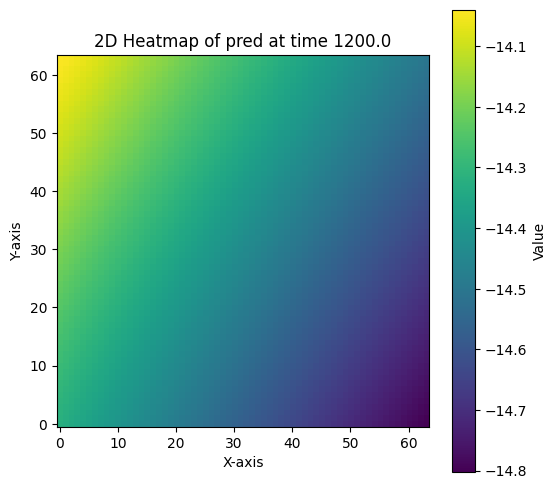

In [11]:
Ttest = inp.get_T(1200)
result,_ = alpha(Xic,Yic,Ttest,g)
resultt = torch.autograd.grad(result, Ttest, torch.ones_like(Ttest))
print(resultt)

result_cpu = result.reshape(N,N).cpu().detach()
result_np = result_cpu.numpy()
plt.figure(figsize=(6, 6))
plt.imshow(result_np, cmap='viridis', origin='lower')
plt.colorbar(label='Value')
plt.title(f"2D Heatmap of pred at time {Ttest[0]}")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [12]:
print(ic_flat)
print(result)
print(max(result))
print(min(result))

tensor([-0.2919, -0.2871, -0.2744,  ..., -0.2861, -0.2921, -0.2855],
       device='cuda:0')
tensor([-14.3229, -14.3311, -14.3393,  ..., -14.4876, -14.4946, -14.5015],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-14.0396, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(-14.8018, device='cuda:0', grad_fn=<UnbindBackward0>)


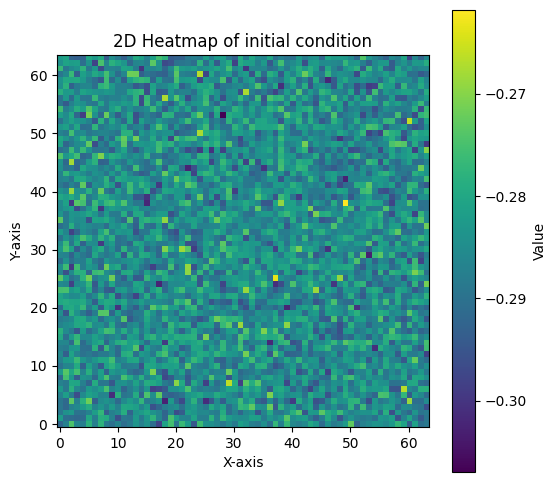

In [13]:
plt.figure(figsize=(6, 6))
plt.imshow(ic_flat.cpu().numpy().reshape(N,N), cmap='viridis', origin='lower')
plt.colorbar(label='Value')
plt.title("2D Heatmap of initial condition")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()